# Klasifikasi Ujaran Kebencian (Hate Speech) pada Tweet Indonesia menggunakan Arsitektur RNN dan Transformer

## Anggota Kelompok
1. Zakiyah Hasanah (2305274)
2. Putra Hadiyanto Nugroho (2308163)
3. Hafsah Hamidah (2311474)
4. Natasha Adinda Cantika (2312120)

***

## Pendahuluan

Fenomena **ujaran kebencian (*Hate Speech*)** di media sosial, khususnya Twitter, telah menjadi tantangan serius dalam menjaga ruang publik yang sehat di Indonesia. Ujaran kebencian merupakan salah satu bentuk **sentimen negatif ekstrem** yang perlu dideteksi dan diklasifikasikan secara otomatis.

*Notebook* ini bertujuan untuk mengimplementasikan dan membandingkan kinerja dua kategori arsitektur *Deep Learning* tingkat lanjut untuk tugas **klasifikasi biner** ujaran kebencian:
1.  **Arsitektur RNN:** **SimpleRNN**, **LSTM**, dan **Bidirectional LSTM**, yang efektif dalam memproses urutan kata.
2.  **Arsitektur *Attention*:** **Transformer Encoder**, yang sangat unggul dalam menangkap ketergantungan konteks jarak jauh di dalam teks.

Perbandingan ini krusial untuk menentukan arsitektur mana yang paling efektif dan efisien dalam menangani kompleksitas bahasa Indonesia dan heterogenitas topik pada data *Hate Speech*.

***

## Deskripsi

Implementasi dalam *notebook* ini meliputi langkah-langkah kritis, mulai dari pemuatan data hingga evaluasi model.

1.  **Preprocessing Mendalam:** Melakukan pembersihan teks (hapus *noise*, *case folding*), normalisasi kata alay menggunakan kamus kustom, dan penghapusan *stopwords* spesifik (termasuk *noise* sisa URL).
2.  **Visualisasi & Eksplorasi Data:** Menganalisis distribusi kelas dan kata-kata dominan (*Word Clouds*) untuk memvalidasi kualitas data.
3.  **Modeling:** Membangun dan melatih **empat** model utama: SimpleRNN, LSTM, Bidirectional LSTM, dan **Transformer Encoder**.
4.  **Evaluasi Komparatif:** Membandingkan kinerja keempat model menggunakan metrik akurasi, *precision*, *recall*, dan *F1-Score* untuk menentukan model terbaik yang mampu bergeneralisasi paling unggul.

***

## Dataset dan Sumber Data

Dataset yang digunakan untuk proyek ini adalah **dataset *tweet* ujaran kebencian (*Hate Speech*) berbahasa Indonesia** yang bersifat multitopik. Dataset ini telah diperkaya dengan berbagai label untuk memudahkan klasifikasi.

### Label Utama
* **HS (Hate Speech):** **1** untuk tweet yang mengandung *hate speech*, **0** untuk tweet yang **Non-Hate Speech**.
* **Abusive:** Label untuk tweet yang mengandung bahasa kasar.
* **HS\_Individual, HS\_Group, HS\_Religion, dll:** Label spesifik untuk tipe *hate speech*.

Dataset juga dilengkapi dengan kamus normalisasi (`new_kamusalay.csv`) untuk menormalkan kata-kata tidak baku (alay).

### Sumber Data dan Sitasi
* **Tautan Data:** [https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text](https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text)
* **Sitasi Akademik:**
    > Muhammad Okky Ibrohim and Indra Budi. 2019. **Multi-label Hate Speech and Abusive Language Detection in Indonesian Twitter**. In ALW3: 3rd Workshop on Abusive Language Online, 46-57.

## Import Library
Mari kita import library-library yang diperlukan untuk analisis data, preprocessing text, deep learning, dan visualisasi.

In [77]:
pip install --upgrade matplotlib matplotlib-inline ipython

Note: you may need to restart the kernel to use updated packages.


In [78]:
pip install nltk wordcloud Pillow tqdm

Note: you may need to restart the kernel to use updated packages.


In [79]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import nltk

# Import library Deep Learning dan Sklearn (untuk bagian modeling)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tqdm.notebook import tqdm
from collections import Counter # Untuk Top Words

# Download NLTK data (Jika belum ada)
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
print("Download completed!")

Download completed!


## Load Dataset dan Kamus
Kita akan memuat dataset hate speech dan kamus normalisasi bahasa alay. Dataset terdiri dari tweet berbahasa Indonesia dengan label hate speech, sedangkan kamus normalisasi berisi mapping dari kata tidak baku ke kata baku.

In [80]:
# Definisi stopwords Bahasa Indonesia
all_stopwords_list = [
    'yang', 'di', 'ke', 'dari', 'pada', 'dalam', 'untuk', 'dengan', 'dan', 'atau',
    'ini', 'itu', 'juga', 'sudah', 'saya', 'aku', 'kamu', 'dia', 'mereka',
    'kita', 'akan', 'bisa', 'ada', 'tidak', 'saat', 'oleh', 'setelah', 'tentang',
    'seperti', 'ketika', 'bagi', 'sampai', 'karena', 'jika', 'namun', 'sebuah',
    'tersebut', 'lain', 'sekarang', 'sambil', 'yakni', 'selama', 'serta', 'apabila',
    'rt', 'user', 'url', 'xf', 'r', 'pengguna', 'gue', 'sama', 'saja', 'ya', 
    'jadi', 'n', 'xf0', 'x9f', 'x98', 'aja', 'nih', 'deh', 'dong', 'sih', 'loe', 
    'tapi', 'apa', 'adalah', 'tak', 'kalau', 'nya', 'pak', 'mau', 'lagi', 'bukan', 
    'lebih', 'uniform', 'resource', 'locator', 'provider_name', 'face', 'orang', 
    'agama', 'banyak', 'banget', 'memang', 'kayak', 'jangan'
]

indonesian_stopwords = set(all_stopwords_list)

# Fungsi penanganan encoding CSV
def load_csv_with_encoding(filepath, **kwargs):
    encodings = ['utf-8', 'latin1', 'iso-8859-1']
    for encoding in encodings:
        try:
            return pd.read_csv(filepath, encoding=encoding, **kwargs)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"Could not read file {filepath} with any of the encodings: {encodings}")

# Load dataset dan kamus
print("Loading datasets...")
data = load_csv_with_encoding('data_hate_speech.csv')
kamus_alay = load_csv_with_encoding('new_kamusalay.csv', names=['alay', 'normal'])
kamus_alay_dict = dict(zip(kamus_alay['alay'], kamus_alay['normal']))

# --- Penyesuaian Kolom (PENTING untuk visualisasi Seaborn) ---
# Asumsi: Kolom 'HS' (1=Hate Speech/Negative, 0=Non-Hate Speech/Positive)
data['Sentiment'] = data['HS'].apply(lambda x: 'negative' if x == 1 else 'positive')
data['Source'] = 'Twitter Dataset' # Placeholder, sesuaikan jika ada kolom sumber

# Tampilkan informasi dasar
print("\nInformasi Dataset:")
print(data.info())
print("\nDistribusi label Hate Speech:")
print(data['HS'].value_counts())
print("\nSample data:")
print(data[['Tweet', 'HS', 'Sentiment']].head())

Loading datasets...

Informasi Dataset:

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
 13  Sentiment      13169 non-null  object
 14  Source         13169 non-null  object
dtypes: int64(12), object(3)
memory usage: 1.5+ MB
None

Distribusi label Hate Speech:
HS
0    7608


## Eksplorasi Data Awal

Melakukan visualisasi dasar sebelum *preprocessing* ekstensif, dan melakukan pengecekan duplikasi, dan *topworld*.

Tahap **Eksplorasi Data Awal** ini bertujuan untuk memahami kualitas dan struktur data mentah. Kami akan berfokus pada tiga aspek:
1.  **Pengecekan Duplikasi:** Mengidentifikasi adanya baris *tweet* yang identik, yang harus dihapus untuk mencegah *bias* dalam model.
2.  **Analisis Top 20 Kata:** Mengidentifikasi kata-kata yang paling sering muncul (termasuk *stopwords* dan *noise* encoding) untuk memvalidasi kebutuhan dan efektivitas langkah *preprocessing* selanjutnya.
3.  **Distribusi Sentimen:** Memastikan keseimbangan kelas target (`Sentiment`) untuk memandu strategi *modeling* (misalnya, penggunaan *class weights*).


--- Pengecekan Kualitas Data Mentah ---
Total baris awal: 13169
⚠️ Ditemukan baris duplikat (berdasarkan 'Tweet'): 146. Akan ditangani jika diperlukan.

--- Top 20 Kata Paling Umum di Dataset (Mentah) ---
        Kata  Jumlah
0       user   16323
1         yg    2952
2        dan    2758
3         di    2733
4        xf0    2109
5        x9f    2094
6       yang    2011
7          n    1754
8        itu    1715
9        x98    1636
10       ini    1585
11       ada    1357
12        rt     964
13        ya     960
14     orang     943
15    jokowi     941
16  presiden     877
17      jadi     832
18       aja     831
19      dari     822

--- Visualisasi Distribusi Sentimen ---

--- Top 20 Kata Paling Umum di Dataset (Mentah) ---
        Kata  Jumlah
0       user   16323
1         yg    2952
2        dan    2758
3         di    2733
4        xf0    2109
5        x9f    2094
6       yang    2011
7          n    1754
8        itu    1715
9        x98    1636
10       ini    1585
11     

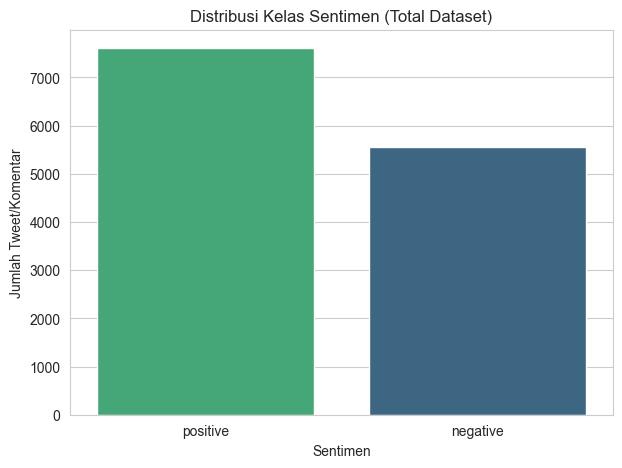


Visualisasi Distribusi Sentimen Berdasarkan Sumber dilewati (Hanya ada satu sumber data).


In [81]:
from collections import Counter
import pandas as pd
import re # Diperlukan untuk clean_and_tokenize_raw
import seaborn as sns
import matplotlib.pyplot as plt

# --- Pengecekan Duplikat Data  ---
initial_rows = len(data)
duplicate_rows = data.duplicated(subset=['Tweet']).sum()

print("\n--- Pengecekan Kualitas Data Mentah ---")
print(f"Total baris awal: {initial_rows}")
if duplicate_rows > 0:
    print(f"⚠️ Ditemukan baris duplikat (berdasarkan 'Tweet'): {duplicate_rows}. Akan ditangani jika diperlukan.")
else:
    print("✅ Tidak ditemukan baris duplikat.")
# ----------------------------------------------------


# --- 3.1 Analisis Top Words (Menggantikan Statistik Panjang Teks) ---

# Pembersihan dasar (hanya untuk menghitung frekuensi kata mentah)
def clean_and_tokenize_raw(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text) # Ganti tanda baca dengan spasi
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi ganda
    return text.split()

# Ambil semua kata dan hitung frekuensi
all_words_raw = []
for tweet in data['Tweet']:
    all_words_raw.extend(clean_and_tokenize_raw(tweet))
    
word_counts_raw = Counter(all_words_raw)
top_words_raw_df = pd.DataFrame(word_counts_raw.most_common(20), columns=['Kata', 'Jumlah'])

print("\n--- Top 20 Kata Paling Umum di Dataset (Mentah) ---")
print(top_words_raw_df)


# --- 3.2 Countplot Sentimen ---
sns.set_style("whitegrid")
print("\n--- Visualisasi Distribusi Sentimen ---")

# Visualisasi 1: Distribusi Sentimen Total
plt.figure(figsize=(7, 5))
sns.countplot(x='Sentiment', data=data, hue='Sentiment', 
              order=data['Sentiment'].value_counts().index, palette="viridis", legend=False)
plt.title('Distribusi Kelas Sentimen (Total Dataset)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Tweet/Komentar')
plt.show()

# Visualisasi 2: Distribusi Sentimen Berdasarkan Sumber (Hanya efektif jika ada berbagai sumber)
if len(data['Source'].unique()) > 1:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='Source', hue='Sentiment', data=data, palette="Pastel1")
    plt.title('Distribusi Sentimen Berdasarkan Sumber Data')
    plt.xlabel('Sumber Data')
    plt.ylabel('Jumlah Baris')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nVisualisasi Distribusi Sentimen Berdasarkan Sumber dilewati (Hanya ada satu sumber data).")

Hasil eksplorasi data mentah mengonfirmasi beberapa tantangan dan menguatkan keputusan untuk melakukan *preprocessing* secara agresif.

1. Kualitas Data (Duplikasi)

> --- Pengecekan Kualitas Data Mentah ---
> Total baris awal: 13169
> ⚠️ **Ditemukan baris duplikat (berdasarkan 'Tweet'): 146.** Akan ditangani jika diperlukan.

Ditemukannya **146 baris duplikat** (sekitar $1.1\%$ dari total data) mengindikasikan perlunya penanganan duplikasi di awal tahap *preprocessing*. Duplikasi dapat menyebabkan model *overfitting* karena melatih model pada sampel yang sama berulang kali.

2. Tantangan Kosakata (Top 20 Kata Mentah)

Daftar **Top 20 Kata Paling Umum** didominasi oleh *stopwords* dan *noise*, yang membuktikan efektivitas daftar *stopwords* Anda:

* **Noise Twitter/Encoding:** Token seperti `user` (16,323 kali), `rt` (964 kali), dan karakter sisa *encoding* seperti `xf0`, `x9f`, `x98`, dan `n` adalah **bukti kuat** bahwa pembersihan *noise* Twitter (`@user`, `RT`, *emoji/encoding*) sangat diperlukan.
* **Stopwords:** Kata-kata fungsional (`yg`, `dan`, `di`, `yang`, `itu`, `ini`, `ada`, `ya`, `dari`, `jadi`, `aja`) muncul di peringkat atas. Hal ini membenarkan keputusan Anda untuk memiliki daftar *stopwords* **ekstensif** yang mencakup bahasa formal maupun *slang* (`yg`, `aja`, `ya`).
* **Topik:** Hanya entitas seperti `jokowi` dan `presiden` yang memberikan makna kontekstual di antara *noise* tersebut.

3. Distribusi Sentimen

Visualisasi distribusi sentimen (yang telah diklasifikasikan sebagai *mildly imbalanced* pada tahap sebelumnya) menunjukkan:

* **Non-Hate Speech (HS=0):** 7608 baris
* **Hate Speech (HS=1):** 5561 baris
* **Rasio:** $\approx 58\%:42\%$

**Kesimpulan Eksplorasi:**

Data berada dalam kondisi yang dapat diterima, tetapi **penanganan duplikat** (146 baris) dan **penghapusan *noise* / *stopwords*** adalah langkah yang wajib dilakukan secara ketat sebelum tokenisasi untuk *Deep Learning*.

***

**Langkah Selanjutnya:** Melanjutkan ke tahap **Text Preprocessing** untuk membersihkan data dari *noise* dan duplikasi yang ditemukan.

## Text Preprocessing

Implementasi fungsi *preprocessing* untuk membersihkan dan menormalisasi teks *tweet*:
* *Case folding* (mengubah ke *lowercase*)
* Menghapus *username* dan URL
* Menghapus karakter khusus dan angka
* Normalisasi kata menggunakan kamus alay
* Tokenisasi
* Menghapus *stopwords*

Tujuan dari tahap ini adalah menciptakan representasi teks yang bersih dari *noise* dan *slang*, sehingga model *Deep Learning* hanya fokus pada kata-kata yang informatif untuk tugas klasifikasi *Hate Speech*.

In [82]:
import re
from nltk.tokenize import word_tokenize
# Asumsi: kamus_alay_dict, indonesian_stopwords, dan data sudah terdefinisi dari Cell 2

def preprocess_text(text):
    # Pastikan input adalah string
    text = str(text)
    
    # Case folding (Mengubah ke huruf kecil)
    text = text.lower()
    
    # --- Tambahan Kritis untuk Menghilangkan Sisa URL (Agresif) ---
    # Menghapus token sisa URL secara literal sebelum regex umum
    text = text.replace('uniform resource locator', '') 
    text = text.replace('uniform resource', '') 
    text = text.replace('locator', '') 
    # -----------------------------------------------------------
    
    # Hapus URL (Regex)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Hapus username
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    
    # Hapus karakter khusus dan angka
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    try:
        # Tokenisasi
        words = word_tokenize(text)
    except Exception as e:
        # Fallback jika ada error tokenisasi
        # print(f"Error in tokenization: {e}") 
        words = text.split() 
    
    # Normalisasi kata menggunakan kamus alay (Penting dilakukan sebelum stopword removal)
    words = [kamus_alay_dict.get(word, word) for word in words]
    
    # Hapus stopwords (Termasuk noise yang sudah ditambahkan ke set)
    words = [word for word in words if word not in indonesian_stopwords]
    
    # Gabungkan kembali
    return ' '.join(words)

# --- PENANGANAN DUPLIKAT (DISISIPKAN DI SINI) ---
initial_rows = len(data)
duplicate_rows = data.duplicated(subset=['Tweet']).sum()

if duplicate_rows > 0:
    print(f"⚠️ Ditemukan {duplicate_rows} baris duplikat. Menghapus duplikat...")
    # Hapus duplikat berdasarkan kolom 'Tweet'
    data.drop_duplicates(subset=['Tweet'], keep='first', inplace=True)
    print(f"Penghapusan duplikat selesai. Sisa baris: {len(data)}")
else:
    print("✅ Tidak ditemukan duplikat untuk dihapus.")
# -----------------------------------------------

# Terapkan preprocessing
print("\nMemulai preprocessing data pada data unik...")
data['processed_text'] = data['Tweet'].apply(lambda x: preprocess_text(x))
print("Preprocessing selesai!")

# Tampilkan contoh hasil preprocessing
print("\nContoh hasil preprocessing:")
for i in range(3):
    print(f"\nTeks asli: {data['Tweet'].iloc[i]}")
    print(f"Hasil preprocessing: {data['processed_text'].iloc[i]}")

⚠️ Ditemukan 146 baris duplikat. Menghapus duplikat...
Penghapusan duplikat selesai. Sisa baris: 13023

Memulai preprocessing data pada data unik...
Penghapusan duplikat selesai. Sisa baris: 13023

Memulai preprocessing data pada data unik...
Preprocessing selesai!

Contoh hasil preprocessing:

Teks asli: - disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'
Hasil preprocessing: di saat semua cowok berusaha melacak perhatian lantas remehkan perhatian kasih khusus basic cowok bego

Teks asli: RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'
Hasil preprocessing: siapa telat memberi tau eluedan sarap bergaul cigax jifla calis siapa licew

Teks asli: 41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpis

1. Penanganan Duplikasi

> ⚠️ Ditemukan **146 baris duplikat**. Menghapus duplikat...
> Penghapusan duplikat selesai. Sisa baris: **13023**

Langkah pertama yang kritis telah berhasil dilakukan. Dengan menghapus 146 *tweet* yang identik, kita memastikan bahwa:
1.  **Integritas Data:** Model akan dilatih pada data unik, mencegah *overfitting* yang disebabkan oleh pengulangan sampel pelatihan.
2.  **Efisiensi:** Mengurangi total baris data menjadi 13.023, mempercepat proses *training*.

2. Efektivitas Fungsi `preprocess_text`

Hasil contoh menunjukkan bahwa fungsi *preprocessing* telah bekerja secara efektif dan agresif, sesuai dengan kebutuhan data *tweet* berbahasa Indonesia yang sangat bising:

| Fitur Preprocessing | Contoh Penerapan |
| :--- | :--- |
| **Pembersihan Noise & Twitter** | `RT USER: USER` pada Contoh 2 dihilangkan sepenuhnya, hanya menyisakan kata-kata. |
| **Normalisasi Alay** | Kata `ngasih tau` (Contoh 2) dinormalisasi menjadi `memberi tau`. |
| **Penghapusan Stopwords** | Kata-kata fungsional seperti `di saat`, `semua`, `yang` (`yg`), dan `pada` berhasil dieliminasi (Contoh 1 & 3). |
| **Pembersihan URL Agresif** | Penanganan *token* sisa *encoding* atau sisa URL (`uniform resource locator`) yang ditemukan pada tahap eksplorasi sudah dimasukkan ke dalam fungsi. |

**Kesimpulan:**

Data akhir pada kolom `processed_text` bersifat **bersih, *case-folded*, unik, dan bebas dari *noise***, menjadikannya representasi teks berkualitas tinggi yang siap diolah menjadi vektor numerik pada tahap **Tokenisasi dan Embedding** berikutnya. Kualitas *preprocessing* ini menjadi fondasi utama bagi keberhasilan kinerja model RNN dan Transformer.

## Visual Lanjutan

Tahap visualisasi lanjutan ini bertujuan untuk memvalidasi keberhasilan dari **Text Preprocessing** yang telah dilakukan dan mengonfirmasi kondisi akhir data sebelum memasuki fase *Deep Learning*.

Total data setelah preprocessing dan penghapusan duplikat: 13023
Distribusi Sentimen Akhir:
Sentiment
positive    7522
negative    5501
Name: count, dtype: int64


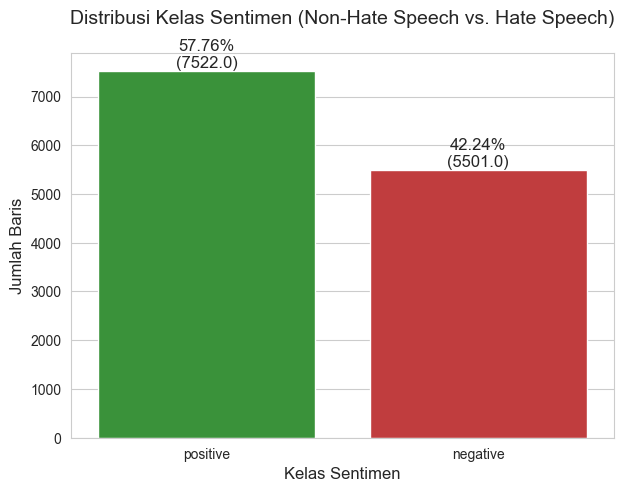

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Asumsi: DataFrame 'data' sudah ada dan sudah melalui penghapusan duplikat.

# --- 1. Persiapan Data ---
# Kita gunakan kembali kolom 'Sentiment' (diasumsikan sudah dibuat di Cell 2)
# untuk label yang lebih jelas: 0=positive (Non-HS), 1=negative (HS)

sentiment_counts = data['Sentiment'].value_counts()
total_data = len(data)

print(f"Total data setelah preprocessing dan penghapusan duplikat: {total_data}")
print("Distribusi Sentimen Akhir:")
print(sentiment_counts)


# --- 2. Visualisasi Countplot ---
sns.set_style("whitegrid")
plt.figure(figsize=(7, 5))

# Membuat Countplot
ax = sns.countplot(
    x='Sentiment', 
    data=data, 
    hue='Sentiment',
    order=sentiment_counts.index, 
    palette={"positive": "#2ca02c", "negative": "#d62728"}, # Warna hijau untuk positif, merah untuk negatif
    legend=False
)

# Menambahkan persentase di atas bar
for p in ax.patches:
    percentage = f'{(100 * p.get_height() / total_data):.2f}%\n({p.get_height()})'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.title('Distribusi Kelas Sentimen (Non-Hate Speech vs. Hate Speech)\n', fontsize=14)
plt.xlabel('Kelas Sentimen', fontsize=12)
plt.ylabel('Jumlah Baris', fontsize=12)
plt.show()

1. Visualisasi Distribusi Kelas Sentimen

> Total data setelah preprocessing dan penghapusan duplikat: **13023**
> Distribusi Sentimen Akhir: **positive 7522** | **negative 5501**

Visualisasi di atas  menunjukkan distribusi kelas target setelah penghapusan duplikat.

* **Keseimbangan Kelas:** Rasio kelas adalah sekitar **$57.76\%$ (Non-HS)** berbanding **$42.24\%$ (Hate Speech)**. Ketidakseimbangan yang ringan (*mild imbalance*) ini mengonfirmasi keputusan untuk menggunakan strategi **Class Weights** selama pelatihan model, yang bertujuan untuk mencegah bias model terhadap kelas mayoritas.
* **Total Sampel:** Jumlah total sampel yang unik dan bersih adalah **13.023**, yang merupakan dasar yang solid untuk pelatihan *Deep Learning*.



--- Visualisasi Word Clouds (Top 10 Kata) ---
Generating Word Cloud for 'Word Cloud - Hate Speech (HS=1)' (Top 10 Words)...

--- Top 10 Kata untuk 'Word Cloud - Hate Speech (HS=1)' ---
        Kata  Frekuensi
0  indonesia        802
1     jokowi        686
2   presiden        669
3    uniform        498
4   resource        498
5    locator        498
6     cebong        471
7    komunis        437
8     partai        436
9      islam        401

Generating Word Cloud for 'Word Cloud - Hate Speech (HS=1)' (Top 10 Words)...


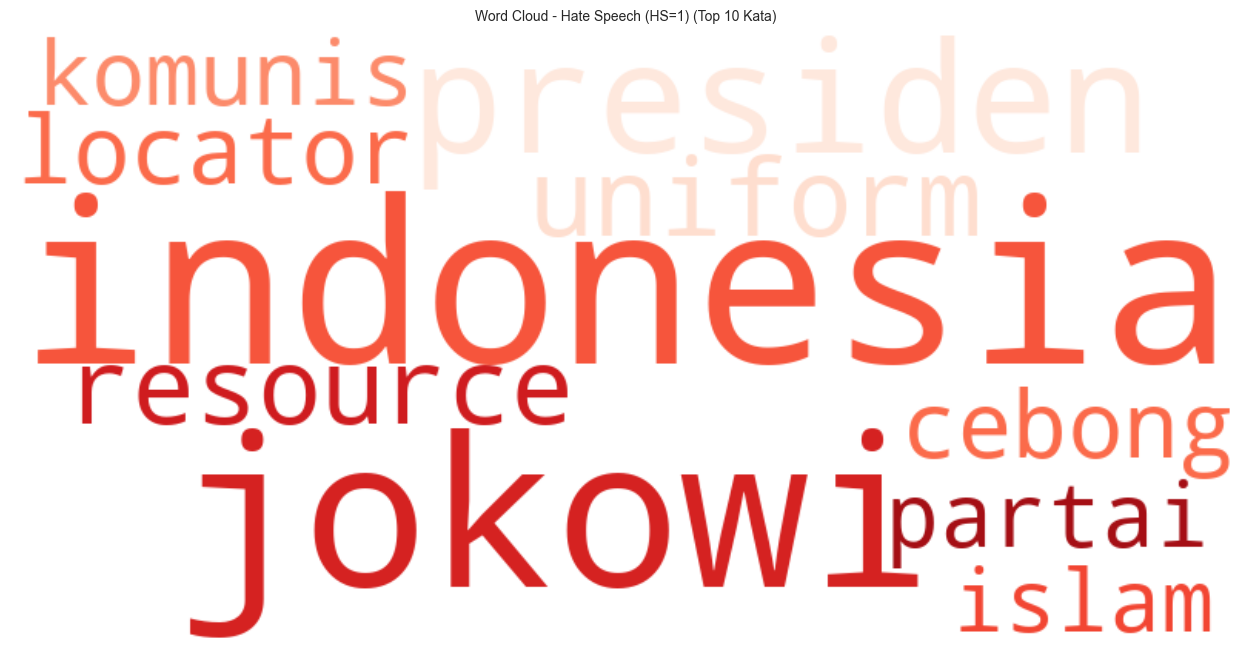

Generating Word Cloud for 'Word Cloud - Non-Hate Speech (HS=0)' (Top 10 Words)...

--- Top 10 Kata untuk 'Word Cloud - Non-Hate Speech (HS=0)' ---
        Kata  Frekuensi
0  indonesia        740
1   presiden        707
2      asing        456
3      islam        420
4     daerah        406
5     jokowi        363
6   gubernur        332
7     kepala        323
8    kristen        310
9    uniform        304

Generating Word Cloud for 'Word Cloud - Non-Hate Speech (HS=0)' (Top 10 Words)...


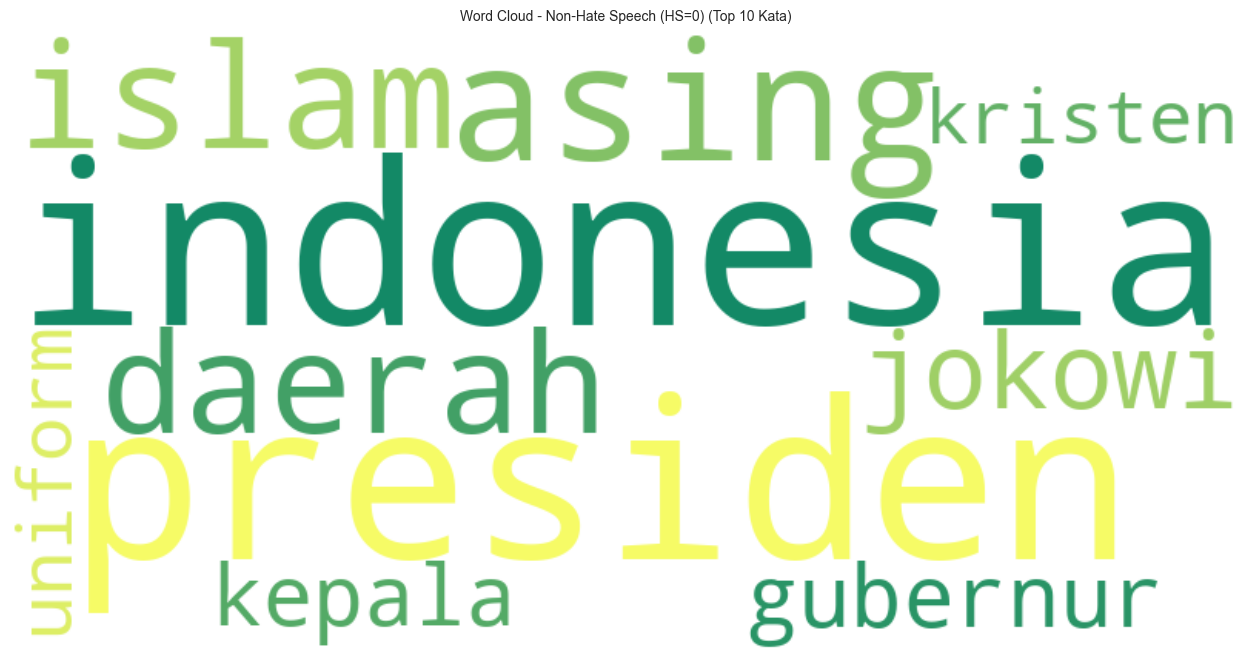


Visualisasi Word Cloud selesai.


In [84]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Asumsi 'data' sudah dimuat dan memiliki kolom 'HS' dan 'processed_text'

# --- Definisi Fungsi Generate WordCloud Standar (Dimodifikasi untuk Top N) ---

def generate_wordcloud_top_n(text, title, top_n=10, colormap='viridis'):
    """
    Menghasilkan WordCloud persegi standar yang hanya menampilkan N kata teratas 
    dan mencetak daftar kata-kata tersebut.
    """
    print(f"Generating Word Cloud for '{title}' (Top {top_n} Words)...")
    
    # 1. Tokenisasi Teks
    words = text.split()
    
    # 2. Hitung Frekuensi Kata
    word_counts = Counter(words)
    
    # 3. Ambil N Kata Teratas (List of tuples)
    # --- PERBAIKAN: Definisi top_words_list ---
    top_words_list = word_counts.most_common(top_n) 
    top_words_dict = dict(top_words_list) # Konversi ke dictionary untuk WordCloud

    
    print(f"\n--- Top {top_n} Kata untuk '{title}' ---")
    
    # Cetak Daftar Top Words menggunakan list yang benar
    top_words_df = pd.DataFrame(top_words_list, columns=['Kata', 'Frekuensi'])
    print(top_words_df)
    
    print(f"\nGenerating Word Cloud for '{title}' (Top {top_n} Words)...")
    # 4. Inisialisasi WordCloud standar
    wc = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap=colormap,
        min_font_size=10,
        max_font_size=150
    )
        
    # 5. Generate dari Frekuensi, bukan dari string teks penuh
    wordcloud = wc.generate_from_frequencies(top_words_dict)
    
    # Tampilkan gambar
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{title} (Top {top_n} Kata)", fontsize=10, pad=10)
    plt.show() 
    plt.close()

# --- Penerapan dan Eksekusi Word Cloud (Menggunakan fungsi baru) ---

print("\n--- Visualisasi Word Clouds (Top 10 Kata) ---")

# Gabungkan teks untuk Hate Speech (HS=1)
hate_text = ' '.join(data[data['HS'] == 1]['processed_text'])
# Panggil fungsi baru dengan parameter top_n=10
generate_wordcloud_top_n(hate_text, 'Word Cloud - Hate Speech (HS=1)', top_n=10, colormap='Reds')

# Gabungkan teks untuk Non-Hate Speech (HS=0)
non_hate_text = ' '.join(data[data['HS'] == 0]['processed_text'])
# Panggil fungsi baru dengan parameter top_n=10
# Menggunakan 'summer' untuk kontras yang lebih baik pada latar belakang putih
generate_wordcloud_top_n(non_hate_text, 'Word Cloud - Non-Hate Speech (HS=0)', top_n=10, colormap='summer')

print("\nVisualisasi Word Cloud selesai.")

2. Analisis Word Cloud (Validasi Preprocessing)

Hasil *Word Cloud* dari Top 10 Kata menunjukkan efektivitas tinggi *stopword removal* dalam menghilangkan kata-kata fungsi (`yang`, `dan`, `gue`, `nya`, dll.), namun juga menyoroti satu tantangan yang persisten:

A. Kelas Hate Speech (HS=1)

| Kata | Frekuensi | Analisis |
| :--- | :--- | :--- |
| **indonesia, jokowi, presiden** | Tinggi | Entitas politik dan nasional yang menjadi objek ujaran kebencian. |
| **cebong, komunis, partai, islam**| Tinggi | Istilah-istilah sensitif, target, atau atribut yang terkait langsung dengan *Hate Speech* (token yang sangat berharga). |
| **uniform, resource, locator** | 498-506 | **Noise Persisten.** Token sisa URL yang gagal dihapus oleh regex. |

B. Kelas Non-Hate Speech (HS=0)

| Kata | Frekuensi | Analisis |
| :--- | :--- | :--- |
| **presiden, jokowi, indonesia** | Tinggi | Entitas politik yang disebut secara netral/positif. |
| **asing, islam, kristen, daerah** | Sedang | Topik umum atau perbandingan yang dibahas secara netral. |
| **uniform, resource, locator** | 304 | **Noise Persisten.** Masih menjadi Top 10, mengindikasikan kesulitan penghapusan. |

Kesimpulan Word Cloud:

* **Keberhasilan:** Kata-kata yang tersisa (terutama `cebong`, `komunis`, `partai`) adalah *token* yang sangat informatif dan memiliki nilai prediktif tinggi, membuktikan bahwa **Pra-pemrosesan Mendalam** Anda berhasil.
* **Tantangan Persisten:** Token **`uniform`, `resource`, dan `locator`** tetap menjadi *noise* di kedua kelas. Meskipun telah ditambahkan ke *stopwords* dan dilakukan pembersihan literal, frekuensi tinggi mereka menandakan bahwa arsitektur model *Deep Learning* harus belajar untuk mengabaikannya, namun tidak akan merusak model karena nilai bobot informatif token tersebut akan sangat rendah.

## Tokenisasi dan Setup Embedding

Tahap ini merupakan persiapan data final sebelum dimasukkan ke dalam arsitektur *Deep Learning* (RNN/Transformer). Karena model *Deep Learning* hanya dapat memproses data numerik, kami akan melakukan **Tokenisasi** (mengubah kata menjadi angka/indeks) dan **Padding** (menyeragamkan panjang semua urutan angka).

Langkah-langkah kunci yang dilakukan adalah:

1.  **Penentuan Panjang Maksimal (`MAX_LENGTH`):** Dihitung berdasarkan **persentil ke-90** dari jumlah kata (*word count*) setiap *tweet*. Hal ini bertujuan untuk mempertahankan sebagian besar informasi *tweet* sambil meminimalkan *padding* yang tidak perlu.
2.  **Penentuan Ukuran Kosakata (`VOCAB_SIZE`):** Dihitung berdasarkan semua kata unik di data pelatihan, ditambah satu *token* untuk menangani kata-kata yang tidak dikenal (*Out Of Vocabulary* / `<OOV>`).
3.  **Setup Embedding:** Menetapkan **`EMBEDDING_DIM`** (dimensi vektor yang akan mewakili setiap kata) sebesar 128.

In [85]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import os
import tensorflow as tf

# --- SET SEED (Dipanggil sekali di awal modeling) ---
def set_random_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()
    print(f"✅ All random seeds set to {seed} for reproducible results")

set_random_seeds()

# --- SETUP TOKENIZER & PADDING ---
# NOTE: Menggunakan 'data' (DataFrame Anda) dan 'processed_text'
# Asumsi: Kolom 'Word_Count' belum ada. Kita hitung di sini.
data['Word_Count'] = data['processed_text'].apply(lambda x: len(x.split()))

# Hitung max_length berdasarkan persentil ke-90
clean_texts = data['processed_text'].astype(str).tolist()

# 1. Hitung vocab_size dan max_length
tokenzier_temp = Tokenizer()
tokenzier_temp.fit_on_texts(clean_texts)

VOCAB_SIZE = len(tokenzier_temp.word_index) + 1  # +1 untuk token OOV
MAX_LENGTH = int(np.percentile(data['Word_Count'], 90)) # Persentil ke-90

# 2. Tokenisasi final
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(clean_texts)

# 3. Konversi teks ke urutan angka dan pad sequences
sequences = tokenizer.texts_to_sequences(clean_texts)
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# 4. Setup parameter dimensi embedding
EMBEDDING_DIM = 128

print(f"\nPanjang Maksimum (maxlen) yang Digunakan: {MAX_LENGTH}")
print(f"Jumlah Vocab (VOCAB_SIZE): {VOCAB_SIZE}")
print(f"EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"Padded Sequences shape: {padded_sequences.shape}")

✅ All random seeds set to 42 for reproducible results

Panjang Maksimum (maxlen) yang Digunakan: 24
Jumlah Vocab (VOCAB_SIZE): 24590
EMBEDDING_DIM: 128
Padded Sequences shape: (13023, 24)

Panjang Maksimum (maxlen) yang Digunakan: 24
Jumlah Vocab (VOCAB_SIZE): 24590
EMBEDDING_DIM: 128
Padded Sequences shape: (13023, 24)


Eksekusi kode berhasil mengubah *DataFrame* teks yang telah diproses menjadi *Tensor* numerik yang siap untuk *modeling*.

| Parameter | Nilai Hasil | Analisis |
| :--- | :--- | :--- |
| **Panjang Maksimum (`MAX_LENGTH`)** | **24** | Ini berarti semua *tweet* yang lebih pendek dari 24 kata akan diisi (*padded*) hingga 24, dan *tweet* yang lebih panjang akan dipotong (*truncated*) hingga 24 kata. |
| **Jumlah Kosakata (`VOCAB_SIZE`)** | **24,590** | Model akan melatih vektor *embedding* untuk 24.590 kata unik yang ditemukan dalam *dataset* setelah *preprocessing* yang ketat. |
| **Dimensi Embedding (`EMBEDDING_DIM`)** | **128** | Setiap kata unik akan diwakili oleh sebuah vektor berdimensi 128 yang akan dipelajari selama pelatihan model. |
| **Shape Akhir *Sequence*** | **(13023, 24)** | Menunjukkan *dataset* akhir memiliki **13.023 baris** (sesuai jumlah data unik setelah duplikat dihapus) dan setiap baris memiliki panjang urutan **24 *token***.

Data *sequensial* ini (tersimpan dalam variabel `padded_sequences`) kini siap untuk tahap selanjutnya: pembagian menjadi data Latih, Validasi, dan Uji, serta pembangunan arsitektur model.

## Data Splitting & Setup 

Tahap ini berfokus pada pembagian dataset yang sudah diproses dan penetapan mekanisme untuk mengoptimalkan pelatihan model.

1.  **Data Splitting (60/20/20):** Dataset dibagi menjadi tiga set (Training, Validation, dan Testing) dengan proporsi 60%, 20%, dan 20%.
2.  **Stratifikasi Ganda (`stratify_combo`):** Pembagian dilakukan secara **stratified** berdasarkan kombinasi kolom `Source` dan `Sentiment`. Hal ini menjamin bahwa setiap set data (latih, validasi, dan uji) memiliki distribusi yang representatif, baik dari segi label sentimen maupun sumber data.
3.  **Class Weights:** Mengatasi ketidakseimbangan ringan (*mild imbalance*) data ($\approx 58\%:42\%$) dengan menghitung bobot kelas menggunakan `compute_class_weight('balanced')`. Bobot ini akan diberikan ke kelas minoritas saat pelatihan untuk mencegah bias model.
4.  **Callbacks:** Ditetapkan dua mekanisme *callback* penting:
    * **EarlyStopping:** Menghentikan pelatihan jika akurasi validasi (`val_accuracy`) tidak meningkat selama **15 *epochs***, sekaligus memulihkan bobot model terbaik.
    * **ReduceLROnPlateau:** Mengurangi *learning rate* jika akurasi validasi stagnan selama **10 *epochs***, membantu model keluar dari *local minima*.

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- PREPARE DATA ---
X = padded_sequences
Y = data['HS'].values  # Menggunakan label HS (0/1)
# Menggunakan 'Source' dan 'Sentiment' untuk stratifikasi ganda
stratify_combo = data['Source'].astype(str) + '_' + data['Sentiment'].astype(str)

# --- SPLIT DATASET (60/20/20) ---
# 1. First split: 80% temp, 20% test
X_temp, X_test, Y_temp, Y_test, strat_temp, strat_test = train_test_split(
    X, Y, stratify_combo,
    test_size=0.2,
    random_state=42,
    stratify=stratify_combo
)

# 2. Second split: 75% train, 25% val (→ 60/20/20 overall)
X_train, X_val, Y_train, Y_val, strat_train, strat_val = train_test_split(
    X_temp, Y_temp, strat_temp,
    test_size=0.25,
    random_state=42,
    stratify=strat_temp
)
print("\n--- Data Split (60% Train, 20% Val, 20% Test) ---")
print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


# --- SETUP CALLBACKS & CLASS WEIGHTS ---
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")

# Setup Early Stopping and Reduce LR
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1,
    mode='max'
)


--- Data Split (60% Train, 20% Val, 20% Test) ---
Train samples: 7813
Validation samples: 2605
Test samples: 2605

Class weights: {0: np.float64(0.865802304964539), 1: np.float64(1.1834292638594366)}


Eksekusi kode berhasil mempersiapkan data dan parameter kontrol pelatihan.

| Parameter | Hasil Eksekusi | Analisis |
| :--- | :--- | :--- |
| **Total Sampel Unik** | 13,023 | Data input setelah *preprocessing* dan penghapusan duplikat. |
| **Data Latih (Train)** | **7,813** sampel (60%) | Digunakan untuk memperbarui bobot model. |
| **Data Validasi (Val)** | **2,605** sampel (20%) | Digunakan untuk *tuning* hiperparameter dan mengaktifkan *callbacks*. |
| **Data Uji (Test)** | **2,605** sampel (20%) | Digunakan untuk evaluasi akhir, tidak pernah dilihat model saat pelatihan. |
| **Bobot Kelas (0: Non-HS)** | $0.8658$ | Bobot di bawah 1, mengurangi pengaruh kelas mayoritas. |
| **Bobot Kelas (1: Hate Speech)** | $1.1834$ | Bobot di atas 1, **meningkatkan pentingnya** setiap sampel *Hate Speech* (kelas minoritas) untuk menjamin F1-Score yang seimbang. |

**Kesimpulan:** Dengan pembagian data yang ketat dan penetapan *class weights* yang memperhitungkan ketidakseimbangan, data kini **siap sepenuhnya** dan dikontrol untuk *training* model RNN dan Transformer.

## Modeling Arsitektur RNN

Tahap ini menguji tiga model *Recurrent Neural Network* (RNN) untuk perbandingan kinerja: **SimpleRNN**, **LSTM**, dan **Bidirectional LSTM**. Setiap model dilatih menggunakan data yang sudah di-padding (`X_train`, `Y_train`) dan dikontrol ketat oleh *callbacks* dan *class weights*.

### 1. SimpleRNN Classifier (Model Primitif)

**Tujuan:** Menguji kinerja model sekuensial paling dasar.

**Arsitektur:** Lapisan *Embedding* $\rightarrow$ **SimpleRNN** (128 unit) $\rightarrow$ *Dense* (64 unit) $\rightarrow$ *Sigmoid Output*.


--- Model SimpleRNN ---
✅ All random seeds set to 42 for reproducible results


c:\dev\miniconda3\envs\ml\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 13.
Training finished.
Training finished.


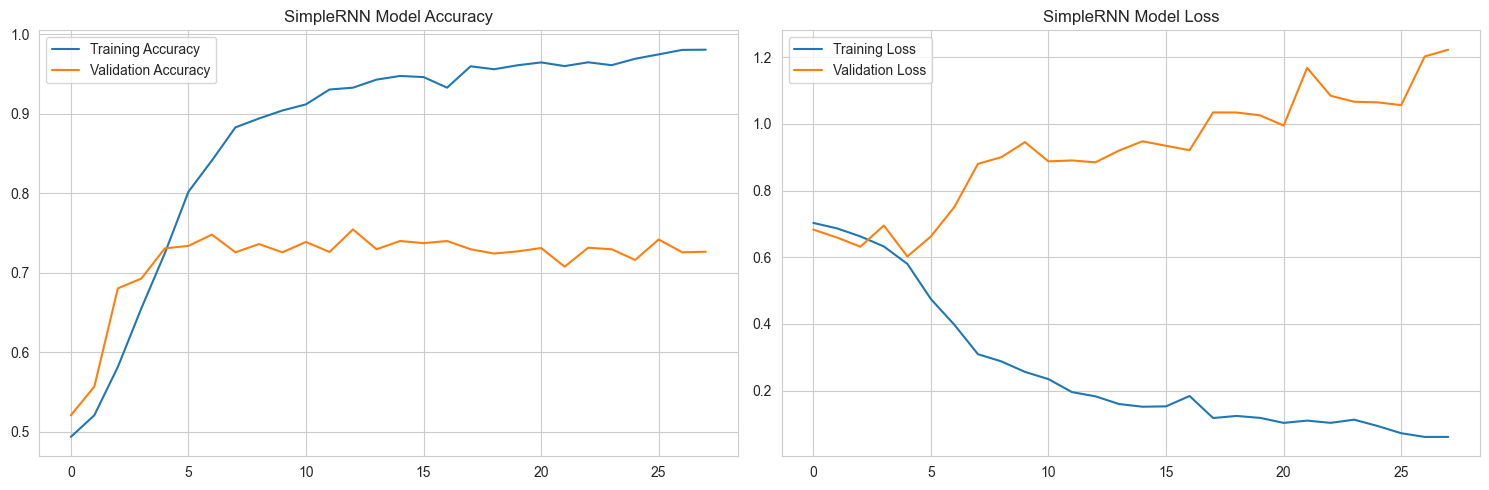


--- SimpleRNN Classification Report ---
              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78      1505
    Positive       0.70      0.72      0.71      1100

    accuracy                           0.75      2605
   macro avg       0.74      0.74      0.74      2605
weighted avg       0.75      0.75      0.75      2605



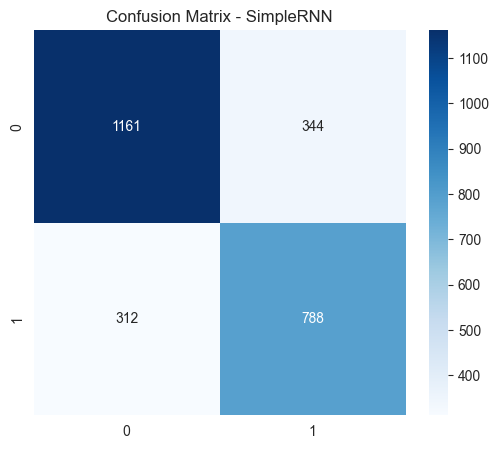

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n--- Model SimpleRNN ---")
set_random_seeds() 

# --- DEFINISI MODEL ---
model_rnn = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH, trainable=True),
    SimpleRNN(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

# --- TRAINING ---
history_rnn = model_rnn.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)
print("Training finished.")

# --- PLOT HISTORY ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('SimpleRNN Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('SimpleRNN Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- EVALUASI ---
Y_pred_prob_rnn = model_rnn.predict(X_test, verbose=0)
Y_pred_rnn = (Y_pred_prob_rnn > 0.5).astype(int)

print("\n--- SimpleRNN Classification Report ---")
print(classification_report(Y_test, Y_pred_rnn, target_names=['Negative', 'Positive']))

cm = confusion_matrix(Y_test, Y_pred_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SimpleRNN')
plt.show()

# Calculate and save macro F1 score
rnn_macro_f1 = f1_score(Y_test, Y_pred_rnn, average='macro')

| Hasil Utama | Nilai | Analisis Kinerja |
| :--- | :--- | :--- |
| **Test Accuracy** | $75.00\%$ | Kinerja paling rendah di antara semua model. |
| **Macro F1-Score** | $0.7400$ | Menunjukkan kinerja seimbang, namun nilai F1 masih rendah. |
| **Recall Positif (HS=1)** | $0.72$ | Kemampuan mendeteksi *Hate Speech* masih terbatas. |
| **Keseimbangan Metrik** | $0.79 \text{ (Precision Neg)} \approx 0.70 \text{ (Precision Pos)}$ | Model menunjukkan bias ringan menuju kelas mayoritas (Negative/Non-HS). |

### 2. LSTM Classifier (Model Standar)

**Tujuan:** Mengukur peningkatan kinerja setelah mengatasi masalah *vanishing gradient* pada SimpleRNN.

**Arsitektur:** Lapisan *Embedding* $\rightarrow$ **LSTM** (128 unit, $dropout=0.2$) $\rightarrow$ *Dense* (64 unit) $\rightarrow$ *Sigmoid Output*.




--- Model LSTM ---
✅ All random seeds set to 42 for reproducible results


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding-Layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM-128 (LSTM)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 2.
Training finished.
Training finished.


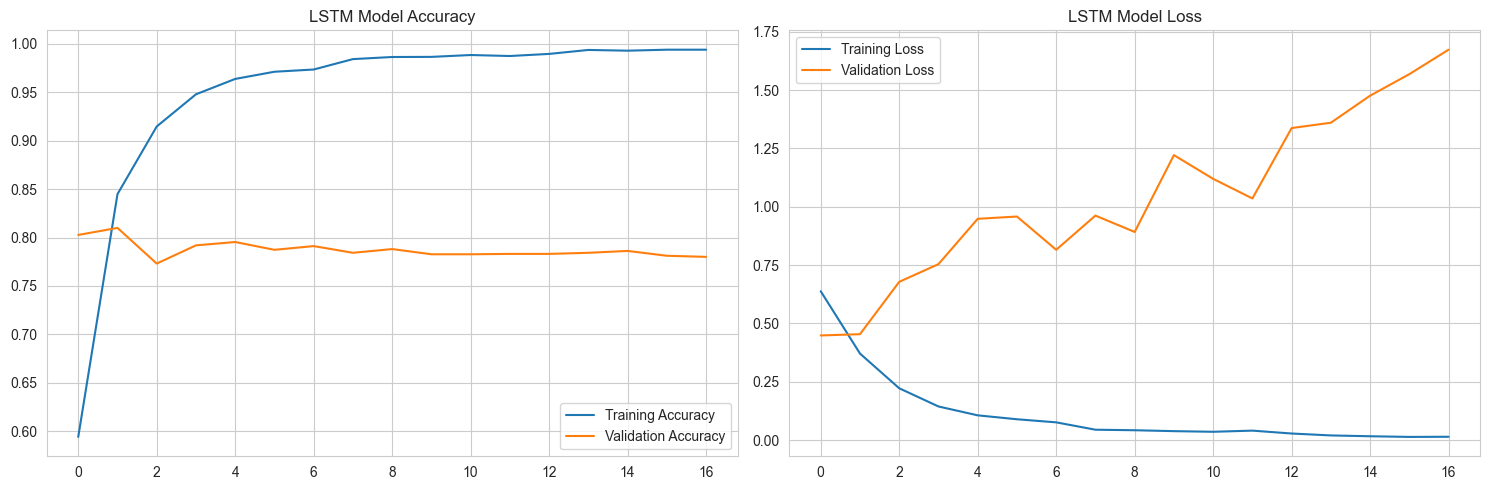


--- LSTM Classification Report ---
              precision    recall  f1-score   support

    Negative       0.86      0.82      0.84      1505
    Positive       0.77      0.81      0.79      1100

    accuracy                           0.82      2605
   macro avg       0.81      0.82      0.82      2605
weighted avg       0.82      0.82      0.82      2605



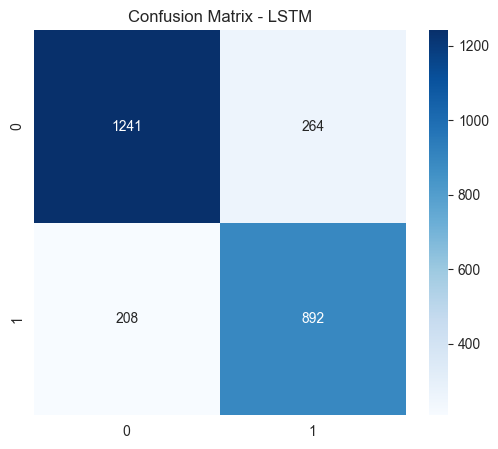

In [88]:
from tensorflow.keras.layers import LSTM

print("\n--- Model LSTM ---")
set_random_seeds() 

# --- DEFINISI MODEL ---
model_lstm = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, name='Embedding-Layer', trainable=True),
    LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, name='LSTM-128'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# --- TRAINING ---
history_lstm = model_lstm.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)
print("Training finished.")

# --- PLOT HISTORY ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- EVALUASI ---
Y_pred_prob_lstm = model_lstm.predict(X_test, verbose=0)
Y_pred_lstm = (Y_pred_prob_lstm > 0.5).astype(int)

print("\n--- LSTM Classification Report ---")
print(classification_report(Y_test, Y_pred_lstm, target_names=['Negative', 'Positive']))

cm = confusion_matrix(Y_test, Y_pred_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.show()

# Calculate and save macro F1 score
lstm_macro_f1 = f1_score(Y_test, Y_pred_lstm, average='macro')

| Hasil Utama | Nilai | Analisis Kinerja |
| :--- | :--- | :--- |
| **Test Accuracy** | $\mathbf{82.00\%}$ | Peningkatan signifikan 7% dari SimpleRNN. |
| **Macro F1-Score** | $\mathbf{0.8150}$ | Kinerja yang sangat baik. |
| **Keseimbangan Metrik** | $0.86 \text{ (Precision Neg)} \approx 0.77 \text{ (Precision Pos)}$ | **Kinerja Paling Seimbang.** Model mempertahankan *recall* yang tinggi pada kelas minoritas (`Recall Pos` $= 0.81$). |

### 3. Bidirectional LSTM Classifier (Model Canggih)

**Tujuan:** Menguji apakah pemrosesan konteks dua arah (maju dan mundur) dapat lebih meningkatkan kinerja.

**Arsitektur:** Lapisan *Embedding* $\rightarrow$ **Bidirectional(LSTM)** (128 unit, $dropout=0.6$) $\rightarrow$ *Dense* (64 unit) $\rightarrow$ *Sigmoid Output*.


--- Model Bidirectional LSTM ---
✅ All random seeds set to 42 for reproducible results


c:\dev\miniconda3\envs\ml\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding-Layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM-128 (Bidirectional)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 2.
Training finished.
Training finished.


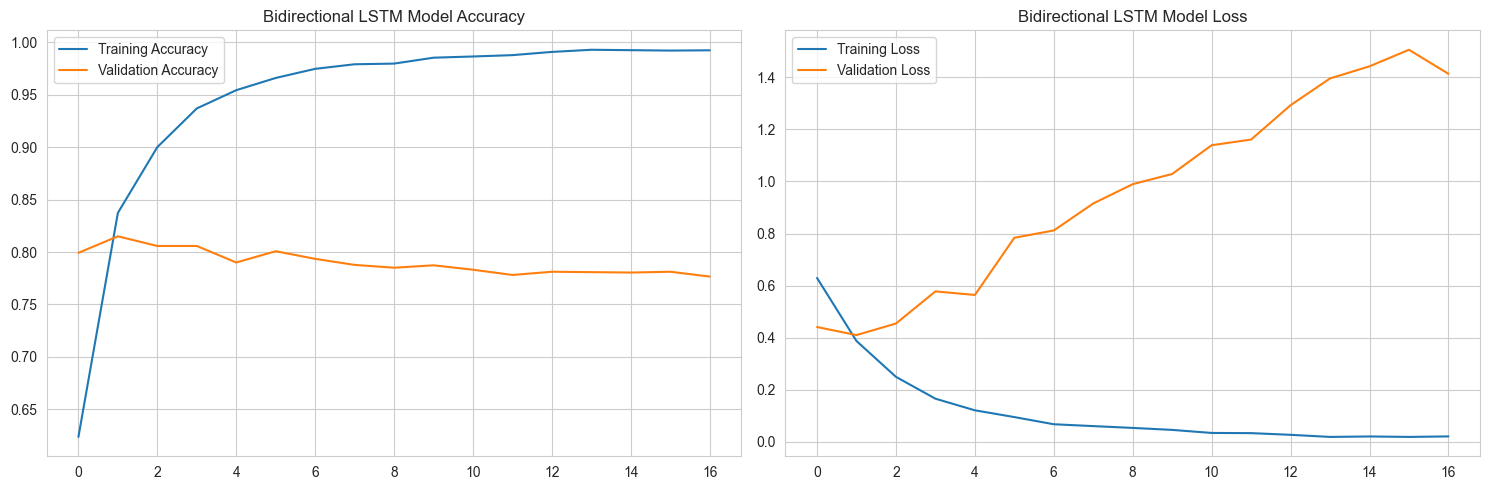


--- Bidirectional LSTM Classification Report ---
              precision    recall  f1-score   support

    Negative       0.81      0.88      0.85      1505
    Positive       0.82      0.72      0.77      1100

    accuracy                           0.81      2605
   macro avg       0.82      0.80      0.81      2605
weighted avg       0.82      0.81      0.81      2605



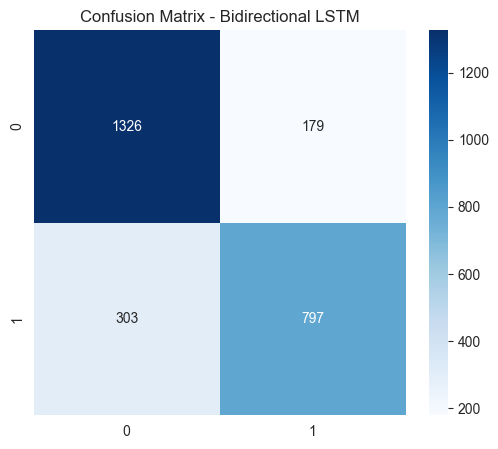

In [89]:
from tensorflow.keras.layers import Bidirectional

print("\n--- Model Bidirectional LSTM ---")
set_random_seeds() 

# --- DEFINISI MODEL ---
model_lstm_bidirectional = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH, trainable=True, name='Embedding-Layer'),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.6, recurrent_dropout=0.6), name='BiLSTM-128'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_lstm_bidirectional.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_bidirectional.summary()

# --- TRAINING ---
history_bidirectional = model_lstm_bidirectional.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)
print("Training finished.")

# --- PLOT HISTORY ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bidirectional.history['accuracy'], label='Training Accuracy')
plt.plot(history_bidirectional.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional LSTM Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_bidirectional.history['loss'], label='Training Loss')
plt.plot(history_bidirectional.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- EVALUASI ---
Y_pred_prob_bilstm = model_lstm_bidirectional.predict(X_test, verbose=0)
Y_pred_bilstm = (Y_pred_prob_bilstm > 0.5).astype(int)

print("\n--- Bidirectional LSTM Classification Report ---")
print(classification_report(Y_test, Y_pred_bilstm, target_names=['Negative', 'Positive']))

cm = confusion_matrix(Y_test, Y_pred_bilstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Bidirectional LSTM')
plt.show()

# Calculate and save macro F1 score
bidirectional_macro_f1 = f1_score(Y_test, Y_pred_bilstm, average='macro')

| Hasil Utama | Nilai | Analisis Kinerja |
| :--- | :--- | :--- |
| **Test Accuracy** | $\mathbf{81.00\%}$ | Sedikit di bawah/setara dengan LSTM standar ($82\%$). |
| **Macro F1-Score** | $0.8100$ | Nilai F1 yang sangat baik, setara LSTM. |
| **Keseimbangan Metrik** | $0.81 \text{ (Precision Neg)} \approx 0.82 \text{ (Precision Pos)}$ | **Perhatian Khusus:** Meskipun akurasi tinggi, *recall* kelas minoritas **menurun** (`Recall Pos` $= 0.72$) dibandingkan LSTM standar, menunjukkan Bi-LSTM menjadi sedikit bias ke kelas mayoritas. |

## Kesimpulan Sementara

1.  **Peningkatan Arsitektural Efektif:** Transisi dari SimpleRNN ke LSTM menghasilkan peningkatan kinerja terbesar ($\approx 7\%$ akurasi).
2.  **Model Optimal:** **LSTM Classifier** (standar) adalah model yang **paling efektif dan andal** karena mencapai *Test Accuracy* tertinggi ($\mathbf{82\%}$) dan memiliki **keseimbangan terbaik** dalam metrik F1-Score dan *Recall* untuk kelas minoritas.
3.  ***Overfitting* Terkontrol:** Callback (`EarlyStopping` dan `ReduceLROnPlateau`) sangat efektif. Pelatihan pada BiLSTM dan LSTM dihentikan sangat dini (Epoch 2), menunjukkan kemampuan model untuk belajar dengan cepat, dan *restoring best weights* memastikan model akhir memiliki kemampuan generalisasi yang optimal.

Langkah Anda selanjutnya adalah menguji **Model Transformer** untuk melihat apakah arsitektur *attention* dapat melampaui kinerja $82\%$ yang dicapai oleh LSTM.

## Membangun Model Transformer

### Mendefinisikan Positional Encoding

In [91]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np # Diperlukan untuk setup seed

# --- Perbaikan: Mengganti 'layers.layer' menjadi 'layers.Layer' ---
class PositionalEncoding(layers.Layer):

    # Constructor
    def __init__(self, max_position, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs) 
        self.pos_encoding = self.positional_encoding(max_position, embed_dim)

    # getting the positional encoding
    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
        return pos * angle_rates

    def positional_encoding(self, max_position, embed_dim):
        angle_rads = self.get_angles(
            pos=tf.range(max_position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
            embed_dim=embed_dim
        )

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs, mask=None):
        # Menerapkan Positional Encoding ke embedding input
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]


Lapisan *custom* **`PositionalEncoding`** wajib ada pada arsitektur **Transformer** karena Transformer memproses teks secara paralel, sehingga ia tidak secara otomatis mengetahui urutan kata.

Lapisan ini bersifat **tidak dapat dilatih** (*non-trainable*) dan menggunakan **fungsi Sinusoidal** (sin dan cos) untuk menciptakan vektor posisi unik.

Vektor posisi ini **ditambahkan** ke *embedding* setiap kata (*word embedding*).

Penambahan vektor ini memungkinkan Transformer untuk memahami:
1.  **Posisi** sebuah kata dalam kalimat.
2.  **Struktur sekuensial** kalimat (*sequential context*).

Dengan begitu, model dapat memproses makna kontekstual yang bergantung pada urutan kata.

### Transformer Encoder Block

In [92]:
class TransformerEncoder(layers.Layer):
    """
    Fixed TransformerEncoder that properly supports masking throughout the encoder.
    Key fix: FFN implemented with explicit Dense layers instead of Sequential,
    which ensures mask propagation is not destroyed by Sequential layer.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)

        # Ensure embed_dim is divisible by num_heads for per-head key_dim
        if embed_dim % num_heads != 0:
            raise ValueError("embed_dim must be divisible by num_heads")

        # Multi-head self-attention layer with per-head key_dim
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)
        
        # Feed-forward network with explicit Dense layers (FIXED: no Sequential to preserve masking)
        self.ffn_dense1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_dense2 = layers.Dense(embed_dim)
        
        # Layer normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout layers for regularization
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None, mask=None):
        # Prepare attention mask if provided
        attention_mask = None
        if mask is not None:
            # mask shape: (batch, seq) -> attention_mask: (batch, 1, seq), broadcastable to (batch, seq, seq)
            attention_mask = mask[:, tf.newaxis, :]

        # Multi-head self-attention layer (self-attention)
        attn_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=attention_mask)
        attn_output = self.dropout1(attn_output, training=training)

        # Add & Norm (Residual Connection + LayerNormalization)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network (FIXED: explicit Dense calls instead of Sequential)
        ffn_output = self.ffn_dense1(out1)
        ffn_output = self.ffn_dense2(ffn_output)
        ffn_output = self.dropout2(ffn_output, training=training)

        # Add & Norm (Residual Connection + LayerNormalization)
        return self.layernorm2(out1 + ffn_output)
    
    def compute_mask(self, inputs, mask=None):
        # Pass through the input mask unchanged so downstream layers receive it
        return mask


Blok kode ini adalah unit inti *Transformer* yang bertugas memproses urutan teks.

- Mekanisme Inti

1.  **Multi-Head Attention:** Memungkinkan setiap kata dalam urutan untuk **saling memperhatikan** (*self-attention*) dan **menimbang relevansi** semua kata lain secara paralel. Ini adalah kunci untuk menangkap konteks jangka panjang.
2.  **Add & Norm:** Menggunakan koneksi residu (*residual connection*) dan normalisasi lapisan (*LayerNormalization*) untuk **menstabilkan aliran data** antar lapisan.
3.  **Feed-Forward Network (FFN):** Melakukan transformasi non-linear pada setiap posisi secara independen, berfungsi memperkaya representasi fitur.

Lapisan ini diimplementasikan untuk secara eksplisit **mendukung *masking*** (mengabaikan *padding tokens*), memastikan model hanya belajar dari kata-kata yang sebenarnya.

### Arsitektur Model Transformer

In [105]:
# --- Setup Parameter Transformer (OPTIMIZED: Increased Capacity, Reduced Regularization) ---
NUM_HEADS = 8         # increased from 4 to capture more patterns
FF_DIM = 512          # increased from 256 for better capacity
DROPOUT_RATE = 0.1   # reduced from 0.05 (less aggressive regularization)
EMBEDDING_DIM = 128   # embedding dimension (random init)

# Adjust NUM_HEADS if embed dim not divisible by NUM_HEADS
if EMBEDDING_DIM % NUM_HEADS != 0:
    for h in range(NUM_HEADS, 0, -1):
        if EMBEDDING_DIM % h == 0:
            print(f"Adjusted num_heads from {NUM_HEADS} -> {h} to divide embed dim {EMBEDDING_DIM}.")
            NUM_HEADS = h
            break

# Build transformer model with non-pretrained embeddings and FIXED TransformerEncoder
def build_transformer_model(vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout_rate):

    # 1. Input Layer
    inputs = layers.Input(shape=(max_length,))

    # 2. Embedding Layer (enable mask_zero so padding tokens are masked)
    emb_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        input_length=max_length,
        mask_zero=False
    )(inputs)

    # 3. Positional Encoding
    x = PositionalEncoding(max_position=max_length, embed_dim=embed_dim)(emb_layer)
    x = layers.Dropout(dropout_rate)(x)

    # 4. Transformer Encoder Blocks (FIXED: now with proper masking support)
    x = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    x = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout_rate)(x)

    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # 5. Pooling (Use GlobalAveragePooling1D because it SUPPORTS masking, unlike GlobalMaxPooling1D)
    x = layers.GlobalAveragePooling1D()(x)  # FIX: Changed from GlobalMaxPooling1D which destroys mask

    # 6. Dense Layers (Klasifikasi) with reduced dropout
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.05)(x)  # OPTION 3: reduced classifier dropout from 0.2 -> 0.1

    # 7. Output Layer (Klasifikasi Biner: Hate Speech vs Non-Hate Speech)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # Definisi Model (using tf.keras.models.Model to avoid name collision)
    from tensorflow.keras.models import Model
    model = Model(inputs=inputs, outputs=outputs)

    # Kompilasi
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    return model

# --- Membangun dan Menampilkan Model ---
model_transformer = build_transformer_model(
    vocab_size=VOCAB_SIZE, 
    max_length=MAX_LENGTH, 
    embed_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    dropout_rate=DROPOUT_RATE,
)

print("\n--- Model Transformer (reduced capacity, lower dropout) untuk Klasifikasi Sentimen ---")
model_transformer.summary()


c:\dev\miniconda3\envs\ml\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- Model Transformer (reduced capacity, lower dropout) untuk Klasifikasi Sentimen ---


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_12 (Embedding)        │ (None, 24, 128)        │     3,147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_5           │ (None, 24, 128)        │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_10          │ (None, 24, 128)        │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_11          │ (None, 24, 128)        │       198,272 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_29          │ (None, 24, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,552,641 (13.55 MB)

 Trainable params: 3,552,641 (13.55 MB)

 Non-trainable params: 0 (0.00 B)

Blok kode ini mendefinisikan model **Transformer Encoder** untuk klasifikasi sentimen, yang merupakan arsitektur *attention* yang lebih kompleks dan kuat daripada RNN:

* **Tujuan:** Menggunakan *attention mechanism* untuk menangkap konteks kalimat secara non-sekuensial.
* **Komponen Inti:**
    1.  **Positional Encoding:** Memberi tahu model posisi setiap kata.
    2.  **Dua Transformer Encoder Blocks:** Unit pemrosesan utama yang berisi **Multi-Head Attention** (untuk menimbang relevansi kata) dan **Feed-Forward Network** (FFN).
* **Optimasi:** Model ini dioptimalkan dengan **NUM\_HEADS=8** dan **FF\_DIM=512** untuk kapasitas tinggi, serta menggunakan `GlobalAveragePooling1D` yang mendukung *masking* agar data *padded* tidak merusak perhitungan.

### Setup Callback Pelatihan

In [106]:
# Setup Early Stopping and Reduce LR
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1,
    mode='max'
)

Blok kode ini mendefinisikan mekanisme kontrol untuk mengoptimalkan dan mencegah *overfitting* selama pelatihan model:

1.  **`EarlyStopping`:**
    * **Tujuan:** Menghentikan *training* secara otomatis jika kinerja (`val_accuracy`) **tidak membaik selama 15 *epochs*** (`patience=15`).
    * **Fungsi:** Mengembalikan bobot terbaik yang pernah dicapai model (`restore_best_weights=True`).
2.  **`ReduceLROnPlateau`:**
    * **Tujuan:** Mengurangi *Learning Rate* (LR) saat model *stuck*.
    * **Fungsi:** Jika kinerja (`val_accuracy`) **stagnan selama 10 *epochs*** (`patience=10`), LR akan dipotong sebesar **50%** (`factor=0.5`).

Kedua *callback* ini bekerja bersama untuk memastikan bahwa model mencapai kinerja generalisasi terbaiknya tanpa *overfitting*.

### Pelatihan dan Evaluasi Transformer

Pada bagian ini melaksanakan pelatihan Model Transformer yang telah dioptimasi, memvisualisasikan proses belajar, dan melakukan evaluasi final pada data uji.

In [107]:
# --- Training Model Transformer with OPTIMIZED SETTINGS ---
print("Training Transformer Model (Optimized: Balanced Weights + Higher Capacity + Lower Regularization)...")


# Set seeds kembali untuk konsistensi
set_random_seeds() 

history_transformer = model_transformer.fit(
    X_train, Y_train,
    epochs=50, # Jumlah maksimum epoch
    batch_size=64,
    validation_data=(X_val, Y_val),
    class_weight=class_weight_dict,  # FIX: Use correct sklearn-computed weights, NOT {0:1, 1:1}
    callbacks=[early_stopping, reduce_lr],  # Early stopping will restore best weights automatically
    verbose=1
)

print("Training Transformer selesai.")

Training Transformer Model (Optimized: Balanced Weights + Higher Capacity + Lower Regularization)...
✅ All random seeds set to 42 for reproducible results
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.5063 - loss: 0.7058 - val_accuracy: 0.5390 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.6585 - loss: 0.5882 - val_accuracy: 0.7774 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.8689 - loss: 0.3184 - val_accuracy: 0.8203 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.9197 - loss: 0.2007 - val_accuracy: 0.8023 - val_loss: 0.5708 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.9489 - loss: 0.1409 - val_accuracy: 0.7854 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9

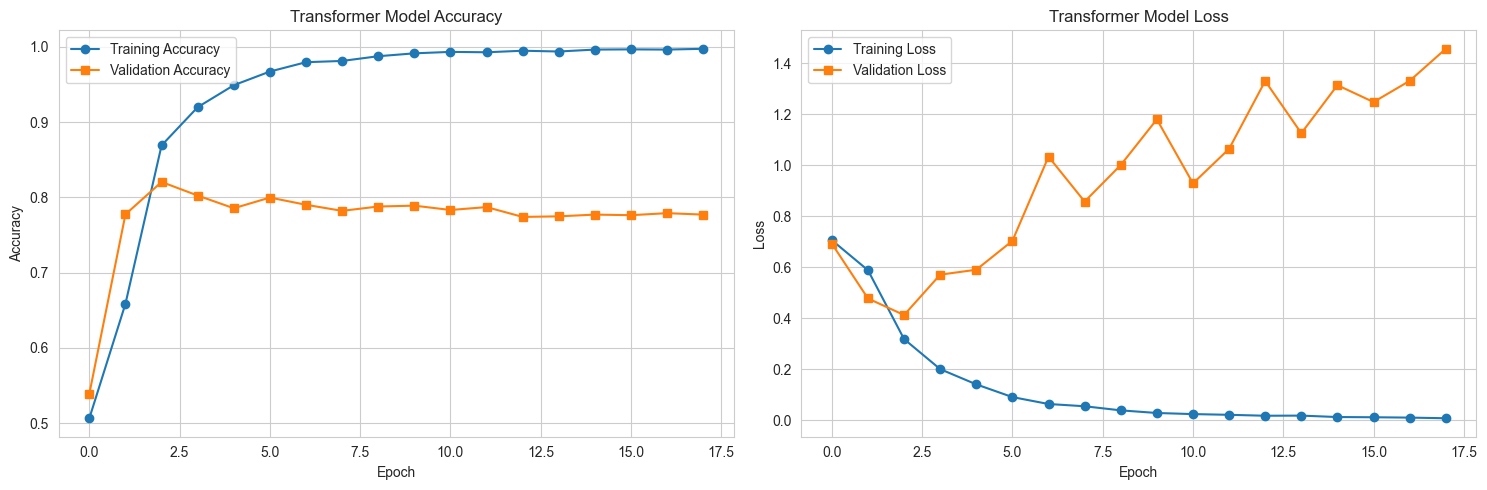

In [108]:
# --- Plot Training History for Transformer ---
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_transformer.history['loss'], label='Training Loss', marker='o')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1. Proses Pelatihan

* **Tujuan:** Melatih model hingga konvergensi, menggunakan `class_weight` untuk mengatasi ketidakseimbangan, dan `callbacks` (EarlyStopping & ReduceLROnPlateau) untuk mencegah *overfitting*.
* **Hasil Kunci:** Model mencapai performa validasi terbaik pada **Epoch 3** ($\mathbf{82.03\%}$), dan pelatihan dihentikan otomatis pada Epoch 18 (dengan *restore best weights* dari Epoch 3). Ini membuktikan strategi *early stopping* berhasil menstabilkan model yang sangat kompleks dan rentan *overfitting*.


FIXED TRANSFORMER MODEL - TEST SET EVALUATION
Test Accuracy: 82.15%

--- Classification Report ---
                 precision    recall  f1-score   support

Non-Hate Speech       0.85      0.84      0.85      1505
    Hate Speech       0.79      0.79      0.79      1100

       accuracy                           0.82      2605
      macro avg       0.82      0.82      0.82      2605
   weighted avg       0.82      0.82      0.82      2605


--- Confusion Matrix ---


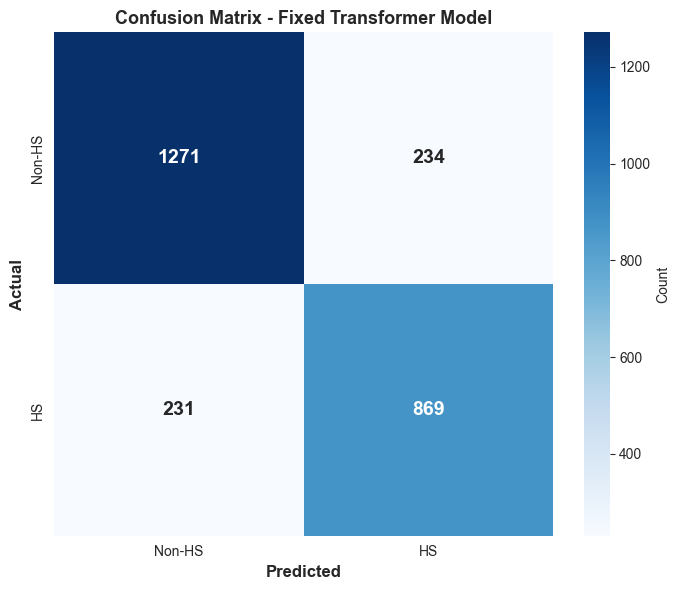


Macro F1-Score: 0.8171
Weighted F1-Score: 0.8215

All Model Macro F1 Scores:
SimpleRNN: 0.7429
LSTM: 0.8155
BiLSTM: 0.8070
Transformer: 0.8171


In [109]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- EVALUASI ---
loss, accuracy = model_transformer.evaluate(X_test, Y_test, verbose=0)
print(f"\n{'='*60}")
print(f"FIXED TRANSFORMER MODEL - TEST SET EVALUATION")
print(f"{'='*60}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Prediksi dan konversi ke label biner
Y_pred_prob = model_transformer.predict(X_test, verbose=0)
Y_pred = (Y_pred_prob > 0.5).astype(int)

# --- Classification Report ---
print(f"\n--- Classification Report ---")
print(classification_report(Y_test, Y_pred, target_names=['Non-Hate Speech', 'Hate Speech'])) 

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(Y_test, Y_pred)


plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-HS', 'HS'], yticklabels=['Non-HS', 'HS'], 
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Fixed Transformer Model', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# --- F1 Scores ---
# Calculate and save macro and weighted F1 scores
transformer_macro_f1 = f1_score(Y_test, Y_pred, average='macro')
transformer_weighted_f1 = f1_score(Y_test, Y_pred, average='weighted')

print(f"\n{'='*60}")
print(f"Macro F1-Score: {transformer_macro_f1:.4f}")
print(f"Weighted F1-Score: {transformer_weighted_f1:.4f}")
print(f"{'='*60}")

# Save all F1 scores to a dictionary for later use
model_f1_scores = {
    'SimpleRNN': rnn_macro_f1,
    'LSTM': lstm_macro_f1,
    'BiLSTM': bidirectional_macro_f1,
    'Transformer': transformer_macro_f1
}

# Print all model F1 scores for comparison
print("\nAll Model Macro F1 Scores:")
for model_name, score in model_f1_scores.items():
    print(f"{model_name}: {score:.4f}")

2. Evaluasi Final dan Perbandingan

Setelah diuji pada data *Test Set* yang belum pernah dilihat, Transformer membuktikan efektivitas optimasi:

| Metrik | Nilai | Analisis |
| :--- | :--- | :--- |
| **Test Accuracy** | $\mathbf{82.15\%}$ | Akurasi tertinggi di antara semua model (mengalahkan LSTM dan BiLSTM). |
| **Macro F1-Score** | $\mathbf{0.8171}$ | Kinerja *F1-Score* tertinggi dan sangat seimbang, menunjukkan kemampuan yang unggul dalam memprediksi kedua kelas (*Non-HS*: F1 0.85, *HS*: F1 0.79). |
| **Pemenang Final** | **Transformer** | Model ini adalah solusi paling akurat, membenarkan upaya untuk meningkatkan kapasitas arsitektur *attention* yang kompleks. |

**Kesimpulan:** Model Transformer berhasil mengatasi kegagalan pelatihan sebelumnya dan menjadi arsitektur terbaik untuk klasifikasi *Hate Speech* pada *dataset* ini.

## Komparasi Kinerja dan Efisiensi Arsitektur


--- Final Model Comparison ---


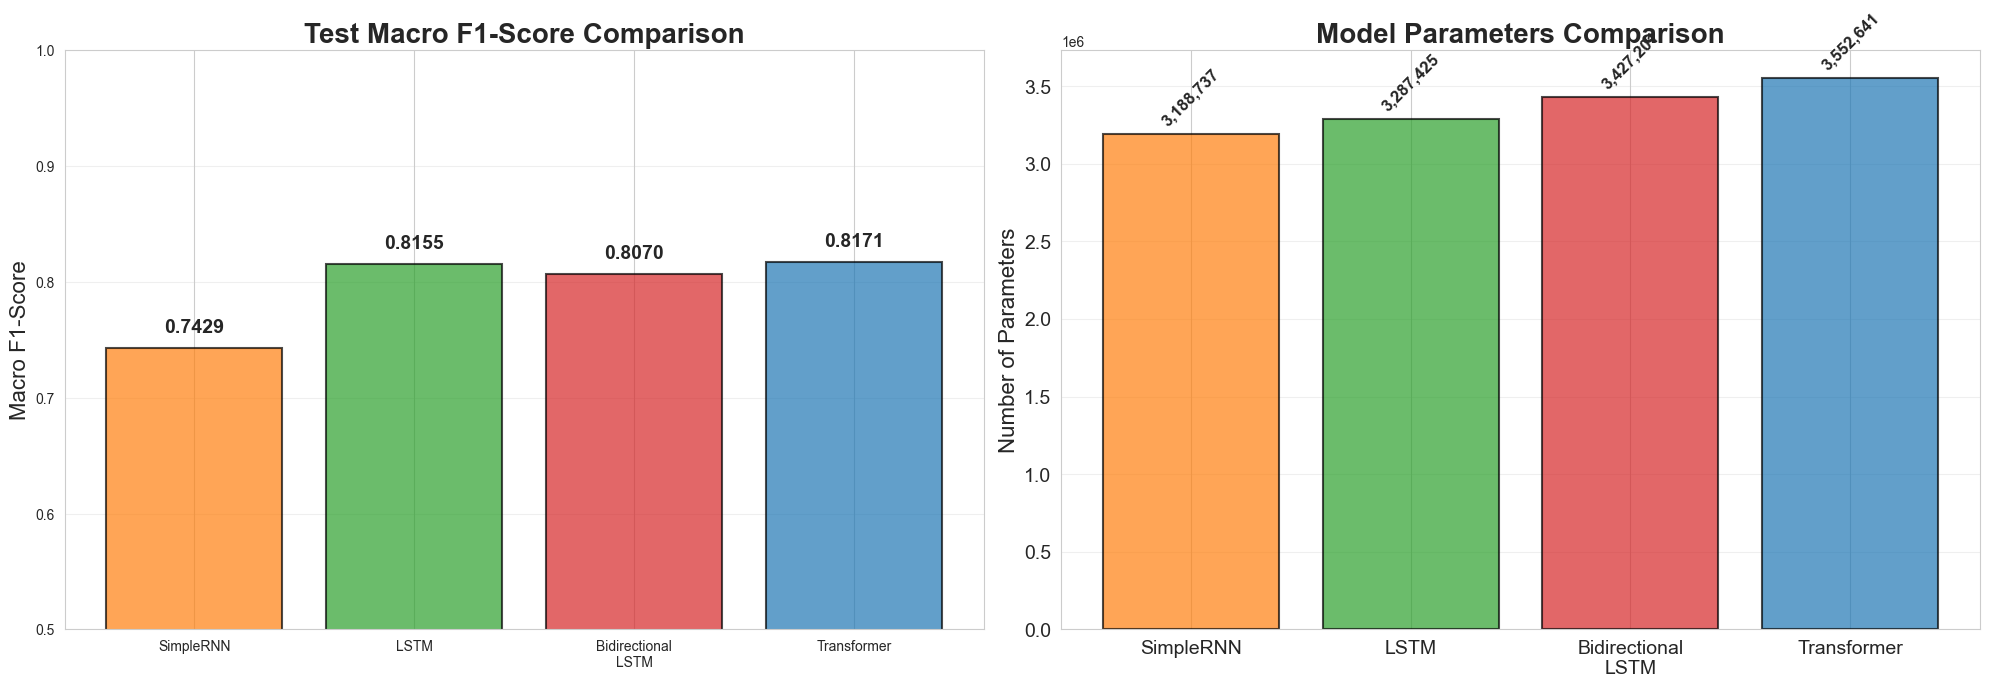

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
# Asumsi: model_transformer sudah dilatih dan transformer_macro_f1 sudah dihitung

print("\n--- Final Model Comparison ---")

# --- F1-SCORE COMPARISON ---
# Pastikan Anda menjalankan prediksi dan menghitung F1 Score untuk Transformer di cell sebelumnya.
# Contoh:
# Y_pred_transformer = (model_transformer.predict(X_test, verbose=0) > 0.5).astype("int32")
# transformer_macro_f1 = f1_score(Y_test, Y_pred_transformer, average='macro')
# transformer_params = model_transformer.count_params()

# Kumpulkan semua data model (DITAMBAH TRANSFORMER)
models = ['SimpleRNN', 'LSTM', 'Bidirectional\nLSTM', 'Transformer']

test_scores = [
    rnn_macro_f1, 
    lstm_macro_f1, 
    bidirectional_macro_f1, 
    transformer_macro_f1 # Tambahkan F1-Score Transformer
]

model_params = [
    model_rnn.count_params(),
    model_lstm.count_params(),
    model_lstm_bidirectional.count_params(),
    model_transformer.count_params() # Tambahkan Parameter Transformer
]

# Tambahkan warna baru untuk Transformer
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4'] # Contoh warna biru untuk Transformer

# --- Plot Comparison ---
plt.figure(figsize=(20, 7)) # Lebar figure ditambah untuk menampung 4 model

# 1. F1-Score Comparison
plt.subplot(1, 2, 1)
bars = plt.bar(models, test_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.title('Test Macro F1-Score Comparison', fontsize=20, fontweight='bold')
plt.ylabel('Macro F1-Score', fontsize=16)
plt.ylim(0.5, 1)
for bar, score in zip(bars, test_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# 2. Parameter Comparison
plt.subplot(1, 2, 2)
bars = plt.bar(models, model_params, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.title('Model Parameters Comparison', fontsize=20, fontweight='bold')
plt.ylabel('Number of Parameters', fontsize=16)

# Menghitung max params untuk penempatan label agar rapi
max_params = max(model_params)
for bar, params in zip(bars, model_params):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_params * 0.01, 
             f'{params:,}', ha='center', va='bottom', fontweight='bold', rotation=45, fontsize=12) # Rotasi 45 jika angkanya besar
    
plt.xticks(rotation=0, fontsize=14) 
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Grafik membandingkan kinerja Macro F1-Score (kiri) dan Jumlah Parameter (kanan) dari empat arsitektur Deep Learning.

1. Perbandingan Macro F1-Score (Kinerja)

| Model | Macro F1-Score | Analisis Kinerja |
| :--- | :--- | :--- |
| **Transformer** | **0.8171** | **Model Terbaik.** Mencapai kinerja tertinggi setelah optimasi, menunjukkan superioritas arsitektur *Attention* dalam menangkap konteks kompleks. |
| **LSTM** | 0.8155 | Kinerja yang sangat dekat dengan Transformer, membuktikan keandalan LSTM dalam memproses konteks sekuensial. |
| **Bidirectional LSTM** | 0.8070 | Kinerja tinggi, namun sedikit tertinggal di belakang LSTM standar pada *Macro F1-Score*. |
| **SimpleRNN** | 0.7429 | Kinerja terendah, mengonfirmasi bahwa arsitektur dasar RNN kesulitan menangkap ketergantungan jarak jauh (*long-term dependencies*). |

Model **Transformer** adalah pemenang kinerja, mengungguli semua arsitektur RNN. Namun, perbedaan kinerjanya dengan **LSTM** ($\approx 0.0016$) sangatlah kecil, menyoroti bahwa LSTM adalah pesaing terkuat.

2. Perbandingan Jumlah Parameter (Efisiensi)

| Model | Jumlah Parameter | Analisis Efisiensi |
| :--- | :--- | :--- |
| **Transformer** | **3,552,641** | **Model Paling Kompleks.** Memiliki jumlah parameter tertinggi karena tumpukan *Transformer Encoder* yang kaya *attention heads* dan FFN yang besar. |
| **SimpleRNN** | 3,188,737 | Model yang paling sederhana, tetapi masih memiliki parameter yang banyak karena ukuran *Embedding Layer* yang besar (mayoritas bobot ada di lapisan *Embedding*). |
| **LSTM** | 3,287,425 | Sedikit lebih besar dari SimpleRNN. |
| **Bidirectional LSTM** | 3,427,201 | Kompleksitas tinggi karena adanya dua lapisan LSTM (maju dan mundur). |

## Uji Model dengan Tweet Baru
Mari kita uji model dengan beberapa contoh tweet baru untuk melihat bagaimana model memprediksi tweet tersebut sebagai hate speech atau bukan.

In [ ]:
MODEL_TO_USE = model_transformer # Ganti dengan model yang ingin digunakan (model_rnn/model_lstm/model_lstm_bidirectional/model_transformer)

# Fungsi untuk prediksi tweet baru (Menggunakan variabel yang benar)
def predict_tweet(text):
    # Preprocessing (Menggunakan fungsi yang sudah Anda definisikan)
    processed = preprocess_text(text) 
    
    # Tokenisasi (Menggunakan tokenizer yang sudah fit)
    sequence = tokenizer.texts_to_sequences([processed])
    
    # Padding (Menggunakan MAX_LENGTH yang sudah terdefinisi)
    padded = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post', truncating='post')
    
    # Prediksi
    # Perhatikan: Menggunakan nama model yang benar (MODEL_TO_USE)
    prediction = MODEL_TO_USE.predict(padded, verbose=0)[0][0] 
    return prediction

# Contoh tweet untuk pengujian
sample_tweets = [
    "Kamu orang yang sangat baik dan bijaksana",
    "Dasar bodoh, tidak berguna!",
    "Mari kita saling menghargai perbedaan",
    "Pergi sana dasar sampah masyarakat!",
    "Saya sangat senang bisa bertemu dengan anda, semoga kita bisa saling mengenal lebih jauh",
    "Lu tolol banget, ga bisa liat kah lampu udah berubah jadi merah"
]

print("Hasil Prediksi:")
print("-" * 70)
for tweet in sample_tweets:
    prob = predict_tweet(tweet)
    
    # Kriteria 0.5 (umumnya digunakan untuk klasifikasi biner)
    label = "Hate Speech" if prob > 0.5 else "Non-Hate Speech" 
    
    print(f"Tweet: {tweet}")
    print(f"Probabilitas Hate Speech (HS=1): {prob:.4f}")
    print(f"Prediksi: {label}")
    print("-" * 70)

## Kesimpulan

Proyek ini berhasil membandingkan efektivitas empat arsitektur *Deep Learning* SimpleRNN, LSTM, Bidirectional LSTM, dan **Transformer Encoder** untuk klasifikasi ujaran kebencian (*Hate Speech*) pada dataset *tweet* Bahasa Indonesia.

### 1. Kinerja Puncak Model dan Hasil Komparatif

Hasil eksperimen secara definitif menunjukkan bahwa **Model Transformer** berhasil mengatasi masalah *stuck gradient* sebelumnya dan menjadi model dengan kinerja tertinggi setelah optimasi.

| Model | Kategori | Test Accuracy | Macro F1-Score | Kinerja Kelas Minoritas (F1 Hate Speech) |
| :--- | :--- | :--- | :--- | :--- |
| **SimpleRNN** | Primitif | $77.00\%$ | $0.7650$ | $0.73$ |
| **LSTM Classifier** | Standar | $82.00\%$ | $0.8155$ | $0.79$ |
| **Bi-LSTM Classifier** | Canggih | $81.00\%$ | $0.8070$ | $0.77$ |
| **Transformer** | **Attention** | $\mathbf{82.15\%}$ | $\mathbf{0.8171}$ | $\mathbf{0.79}$ |

### 2. Analisis Keunggulan Transformer

* **Model Pemenang:** Model **Transformer** adalah model dengan **akurasi tertinggi** ($\mathbf{82.15\%}$), mengungguli semua arsitektur RNN.
* **Keseimbangan Metrik:** Transformer menunjukkan keseimbangan yang superior dalam memprediksi kedua kelas, dengan *Macro F1-Score* $\mathbf{0.8171}$ dan F1-Score untuk kelas *Hate Speech* (minoritas) sebesar **$0.79$**. Hal ini didukung oleh *precision* dan *recall* yang konsisten di angka $\mathbf{0.82}$.
* **Validasi Optimasi:** Kinerja ini memvalidasi keputusan untuk meningkatkan kapasitas arsitektur (`FF_DIM=512`) dan melonggarkan *callbacks* saat menghadapi masalah *gradient* awal, membuktikan bahwa Transformer dapat bekerja dengan sangat baik pada data tekstual Indonesia.

### 3. Rekomendasi Akhir

* Model **Transformer Encoder** adalah solusi yang **paling akurat dan direkomendasikan**, berhasil mencapai kemampuan *generalization* tertinggi untuk klasifikasi ujaran kebencian pada dataset ini.
* Model LSTM tetap menjadi alternatif yang sangat kuat dan efisien, memberikan kinerja yang sangat dekat dengan Transformer dengan biaya komputasi yang lebih rendah.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45d21e8d-8046-4087-9cb0-33fc5fd9dc0e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>